## 模型1：Pytorch RNN 实现流程
       1.加载数据集
       2.使得数据集可迭代（每次读取一个Batch）
       3.创建模型类
       4.初始化模型类
       5.初始化损失类
       6.训练模型

In [1]:
# 1.加载数据集
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 2.下载mnist数据集
trainsets = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()) # 格式转换

testsets = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [3]:
class_names = trainsets.classes # 查看类别/标签

print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
# 3.查看数据集的大小shape

print(trainsets.data.shape)

torch.Size([60000, 28, 28])


In [5]:
print(trainsets.targets.shape)

torch.Size([60000])


In [6]:
print(testsets.data.shape)

torch.Size([10000, 28, 28])


In [7]:
print(testsets.targets.shape)

torch.Size([10000])


In [8]:
# 4.定义超参数
BATCH_SIZE = 32 # 每批读取的数据大小
EPOCHS = 10 # 训练10轮

In [9]:
# 5.创建数据集的可迭代对象，也就是说一个batch一个batch的读取数据
train_loader = torch.utils.data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# 查看一批batch的数据

images, labels = next(iter(test_loader))

In [11]:
print(images.shape)

torch.Size([32, 1, 28, 28])


In [12]:
print(labels.shape)

torch.Size([32])


In [13]:
# 6.定义函数：显示一批数据
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # 均值
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # 像素值限制在0-1之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

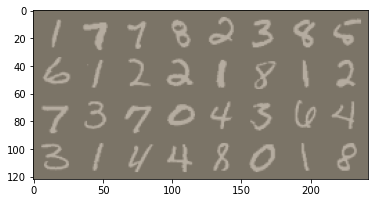

In [14]:
# 网格显示
out = torchvision.utils.make_grid(images)

imshow(out)

In [15]:
# 7.定义RNN模型
class RNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

In [25]:
# 8.初始化模型
input_dim = 28 # 输入维度
hidden_dim = 100 # 隐层的维度
layer_dim = 2 # 2层RNN
output_dim = 10 # 输出维度


# 判断是否有GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = RNN_Model(input_dim, hidden_dim, layer_dim, output_dim).to(device)

In [26]:
# 9.定义损失函数
criterion = nn.CrossEntropyLoss()

In [27]:
# 10.定义优化器
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
# 11.输出模型参数信息
length = (len(list(model.parameters())))

In [29]:
# 12.循环打印模型参数
for i in range(length):
    print('参数：%d'%(i+1))
    print(list(model.parameters())[i].size())

参数：1
torch.Size([100, 28])
参数：2
torch.Size([100, 100])
参数：3
torch.Size([100])
参数：4
torch.Size([100])
参数：5
torch.Size([100, 100])
参数：6
torch.Size([100, 100])
参数：7
torch.Size([100])
参数：8
torch.Size([100])
参数：9
torch.Size([10, 100])
参数：10
torch.Size([10])


In [30]:
# 13.模型训练
sequence_dim = 28 # 序列长度
loss_list = [] # 保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 保存循环次数

iter = 0
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        model.train() # 声明训练
        # 一个batch的数据转换为RNN的输入维度
        images = images.view(-1, sequence_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval() # 声明
            # 计算验证的accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集，获取数据、预测
            for images, labels in test_loader:
                images = images.view(-1, sequence_dim, input_dim).to(device)
                # 模型预测
                outputs = model(images)
                # 获取预测概率最大值的下标
                predict = torch.max(outputs.data, 1)[1]
                # 统计测试集的大小
                total += labels.size(0)
                # 统计判断/预测正确的数量
                if torch.cuda.is_available():
                    correct += (predict.cuda() == labels.cuda()).sum()
                else:
                    correct += (predict == labels).sum()
            # 计算
            accuracy = correct / total * 100
            # 保存accuracy，loss，iteration
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print("loop : {}, Loss : {}, Accuracy : {}".format(iter, loss.item(), accuracy))

loop : 500, Loss : 2.2837369441986084, Accuracy : 11.350000381469727
loop : 1000, Loss : 2.3067047595977783, Accuracy : 15.140000343322754
loop : 1500, Loss : 2.2430574893951416, Accuracy : 19.479999542236328
loop : 2000, Loss : 2.0524306297302246, Accuracy : 27.5
loop : 2500, Loss : 1.0097459554672241, Accuracy : 57.97999954223633
loop : 3000, Loss : 1.222208023071289, Accuracy : 74.38999938964844
loop : 3500, Loss : 0.5925147533416748, Accuracy : 80.53999328613281
loop : 4000, Loss : 0.22395697236061096, Accuracy : 85.8499984741211
loop : 4500, Loss : 0.20246045291423798, Accuracy : 87.65999603271484
loop : 5000, Loss : 0.4408451020717621, Accuracy : 89.5
loop : 5500, Loss : 0.27596282958984375, Accuracy : 91.69999694824219
loop : 6000, Loss : 0.31333136558532715, Accuracy : 90.8499984741211
loop : 6500, Loss : 0.2981404960155487, Accuracy : 91.63999938964844
loop : 7000, Loss : 0.4085048735141754, Accuracy : 91.14999389648438
loop : 7500, Loss : 0.22486254572868347, Accuracy : 93.82

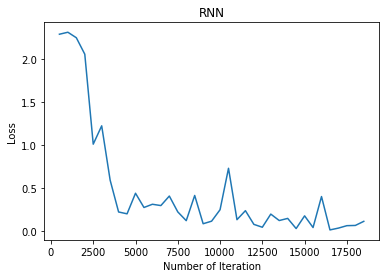

In [31]:
# 可视化 loss
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('RNN')
plt.show()

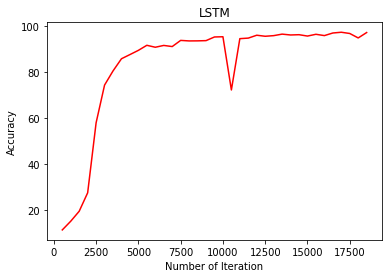

In [32]:
# 可视化 accuracy
plt.plot(iteration_list, accuracy_list, color='r')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTM_mnist.png')
plt.show()

## 模型2：LSTM 实现流程
       1.加载数据集
       2.使得数据集可迭代（每次读取一个Batch）
       3.创建模型类
       4.初始化模型类
       5.初始化损失类
       6.训练模型

In [52]:
# 1.定义RNN模型
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model, self).__init__() # 初始化父类中的构造方法
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # 构建LSTM模型
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # 初始化隐层状态全为0
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 初始化cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 分离隐藏状态，避免梯度爆炸
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # 只需要最后一层隐层的状态
        out = self.fc(out[:, -1, :])
        return out

In [53]:
# 2.初始化模型
input_dim = 28 # 输入维度，图片是28×28
hidden_dim = 100 # 隐层的维度100
layer_dim = 1 # 1个隐层
output_dim = 10 # 输出维度：10，即0-9共10个数字


# 判断是否有GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LSTM_Model(input_dim, hidden_dim, layer_dim, output_dim).to(device)

In [54]:
# 3.循环打印模型参数
for i in range(len(list(model.parameters()))):
    print('参数：%d' %(i+1))
    print(list(model.parameters())[i].size())

参数：1
torch.Size([400, 28])
参数：2
torch.Size([400, 100])
参数：3
torch.Size([400])
参数：4
torch.Size([400])
参数：5
torch.Size([10, 100])
参数：6
torch.Size([10])


In [55]:
# 4.初始化损失函数
criterion = nn.CrossEntropyLoss()

# 5.初始化优化器
learning_rate = 0.02

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [56]:
# 6.模型训练
sequence_dim = 28 # 序列长度
loss_list = [] # 保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 保存循环次数

iter = 0
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        model.train() # 声明训练
        # 一个batch的数据转换为RNN的输入维度
        images = images.view(-1, sequence_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval() # 声明
            # 计算验证的accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集，获取数据、预测
            for images, labels in test_loader:
                images = images.view(-1, sequence_dim, input_dim).to(device)
                # 模型预测
                outputs = model(images)
                # 获取预测概率最大值的下标
                predict = torch.max(outputs.data, 1)[1]
                # 统计测试集的大小
                total += labels.size(0) # label.size(0) = 32，即一个batchsize的大小
                # 统计判断/预测正确的数量
                if torch.cuda.is_available():
                    correct += (predict.cuda() == labels.cuda()).sum()
                else:
                    correct += (predict == labels).sum()
            # 计算accuracy
            accuracy = correct / total * 100
            # 保存accuracy，loss，iteration
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print("loop : {}, Loss : {}, Accuracy : {}".format(iter, loss.item(), accuracy))

loop : 500, Loss : 2.29343318939209, Accuracy : 12.539999008178711
loop : 1000, Loss : 2.288612127304077, Accuracy : 13.130000114440918
loop : 1500, Loss : 2.304539918899536, Accuracy : 15.130000114440918
loop : 2000, Loss : 2.292093276977539, Accuracy : 19.280000686645508
loop : 2500, Loss : 2.233530282974243, Accuracy : 18.010000228881836
loop : 3000, Loss : 2.200453519821167, Accuracy : 24.44999885559082
loop : 3500, Loss : 2.015127420425415, Accuracy : 29.749998092651367
loop : 4000, Loss : 1.5919729471206665, Accuracy : 49.82999801635742
loop : 4500, Loss : 1.0491276979446411, Accuracy : 63.80000305175781
loop : 5000, Loss : 0.7047128677368164, Accuracy : 75.13999938964844
loop : 5500, Loss : 0.838798463344574, Accuracy : 82.08000183105469
loop : 6000, Loss : 0.20251838862895966, Accuracy : 85.42999267578125
loop : 6500, Loss : 0.304369181394577, Accuracy : 87.08999633789062
loop : 7000, Loss : 0.5471338629722595, Accuracy : 86.52999877929688
loop : 7500, Loss : 0.5759539604187012

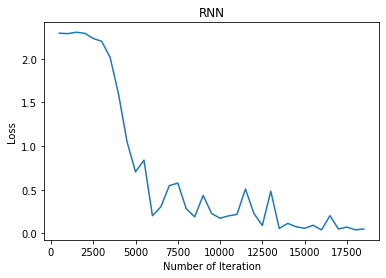

In [57]:
# 可视化 loss
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('RNN')
plt.show()

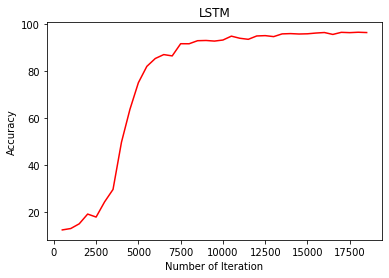

In [58]:
# 可视化 accuracy
plt.plot(iteration_list, accuracy_list, color='r')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTM_mnist.png')
plt.show()